In [2]:
!pip install beautifulsoup4
!pip install requests
!pip install emoji

     |████████████████████████████████| 51kB 3.0MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49717 sha256=f6d07d48bece0d98427e414acae492f38648a94e816d83bf9542a9c9f1736f5b
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from os import path
import re

from tqdm.notebook import tqdm

from bs4 import BeautifulSoup

import requests
import emoji

In [5]:
memes_path = "/content/drive/MyDrive/memes"
memes_df = pd.read_excel(path.join(memes_path, "mems_metadata.xlsx"), index_col=0)
emoji_df = pd.read_csv(path.join(memes_path, "out.csv"), index_col=0)
memes_df = memes_df[memes_df['memedate'].notna()]

In [6]:
di = {
    'no date': -1,
    '1 week ago': 0,
    '2 weeks ago': 0,
    '3 weeks ago': 0,
    '4 weeks ago': 0,
    '1 month ago': 0,
    '2 months ago': 0,
    '3 months ago': 0,
    '4 months ago': 0,
    '5 months ago': 0,
    '6 months ago': 0,
    '7 months ago': 0,
    '8 months ago': 0,
    '9 months ago': 0,
    '10 months ago': 0,
    '11 months ago': 0,
    '1 year ago': 1,
    '2 years ago': 2,
    '3 years ago': 3,
    '4 years ago': 4,
    '5 years ago': 5,
    '6 years ago': 6,
    '7 years ago': 7,
    '8 years ago': 8,
    '9 years ago': 9,
    '10 years ago': 10,
}
memes_df['memedate_number'] = memes_df['memedate'].map(di)

In [7]:
memes_df.head()

,ID,imgviews,imgvotes,comments,memedate,imgname,imgtext,tags,Unnamed: 9,Unnamed: 10,Unnamed: 11,memedate_number
0,10769j,22045.0,203,259,5 years ago,Hide the Pain Harold Meme,"OOOH, A COMMENT ON MY MEME. IT'S A PICTURE O...","memes,hide the pain harold",NaN,NaN,NaN,5.0
1,10e3sj,4166.0,64,24,5 years ago,One Does Not Simply Meme,ONE DOES NOT SIMPLY; RESIST BACON,"memes,one does not simply",NaN,NaN,NaN,5.0
2,115m4j,18689.0,176,42,no date,Batman Slapping Robin Meme,DON'T GIVE ME THE SILENT TREATMENT!,"memes,batman slapping robin",NaN,NaN,NaN,-1.0
3,11qu1m,20392.0,270,52,5 years ago,The Rock Driving Meme,"YA KNOW WHAT, YOU NEED TO THINK OUTSIDE THE ...","memes,the rock driving",NaN,NaN,NaN,5.0
4,11v8a,50536.0,61,6,8 years ago,One Does Not Simply Meme,ONE DOES NOT SIMPLY STAY AWAKE IN CLASS,"memes,one does not simply",NaN,NaN,NaN,8.0


In [8]:
emoji_df.head()

,:joy:,:unamused:,:weary:,:sob:,:heart_eyes:,:pensive:,:ok_hand:,:blush:,:heart:,:smirk:,:grin:,:notes:,:flushed:,:100:,:sleeping:,:relieved:,:relaxed:,:raised_hands:,:two_hearts:,:expressionless:,:sweat_smile:,:pray:,:confused:,:kissing_heart:,:heartbeat:,:neutral_face:,:information_desk_person:,:disappointed:,:see_no_evil:,:tired_face:,:v:,:sunglasses:,:rage:,:thumbsup:,:cry:,:sleepy:,:yum:,:triumph:,:hand:,:mask:,:clap:,:eyes:,:gun:,:persevere:,:smiling_imp:,:sweat:,:broken_heart:,:yellow_heart:,:musical_note:,:speak_no_evil:,:wink:,:skull:,:confounded:,:smile:,:stuck_out_tongue_winking_eye:,:angry:,:no_good:,:muscle:,:facepunch:,:purple_heart:,:sparkling_heart:,:blue_heart:,:grimacing:,:sparkles:
10769j,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
10e3sj,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
115m4j,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0
11qu1m,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
11v8a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


## Попытка анализа

In [9]:
cols = emoji_df.columns
temp = []
for row in emoji_df.itertuples():
    for i in range(1, len(cols)):
        if row[i] > 0:
            temp.append((row[0], cols[i]))

emoji_flat = pd.DataFrame(temp, columns=['id', 'emoji'])
emoji_flat

,id,emoji
0,10769j,:unamused:
1,10769j,:weary:
2,10769j,:sweat_smile:
3,10769j,:information_desk_person:
4,10769j,:confounded:
...,...,...
32240,4hahoi,:unamused:
32241,4hahoi,:100:
32242,4hahoi,:tired_face:
32243,4hahoi,:gun:


In [10]:
distribution = emoji_flat.emoji.value_counts() / len(emoji_flat)
with open('emoji_distribution.txt', 'w') as f:
    for i, value in enumerate(distribution):
        print(f"{emoji.emojize(distribution.index[i], use_aliases=True)}: {value:.1%}", file=f)

In [11]:
emoji_img = pd.merge(memes_df, emoji_flat, how='right', left_on='ID', right_on='id')

In [12]:
drop_cols = ['memedate', 'tags', 'Unnamed: 9', 'Unnamed: 10', 
             'Unnamed: 11', 'id', 'imgname', 'imgtext']
emoji_img = emoji_img.drop(drop_cols, axis=1)
emoji_img

,ID,imgviews,imgvotes,comments,memedate_number,emoji
0,10769j,22045.0,203.0,259.0,5.0,:unamused:
1,10769j,22045.0,203.0,259.0,5.0,:weary:
2,10769j,22045.0,203.0,259.0,5.0,:sweat_smile:
3,10769j,22045.0,203.0,259.0,5.0,:information_desk_person:
4,10769j,22045.0,203.0,259.0,5.0,:confounded:
...,...,...,...,...,...,...
32270,4hahoi,2198.0,26.0,0.0,-1.0,:unamused:
32271,4hahoi,2198.0,26.0,0.0,-1.0,:100:
32272,4hahoi,2198.0,26.0,0.0,-1.0,:tired_face:
32273,4hahoi,2198.0,26.0,0.0,-1.0,:gun:


In [15]:
grouping = emoji_img.groupby(['memedate_number', 'emoji'])
new_emoji = grouping[[x for x in emoji_img.columns if x not in ['ID', 'memedate_number', 'emoji']]].max()
new_emoji['file count'] = grouping['ID'].count()
new_emoji

imgviews  imgvotes  comments  file count
memedate_number emoji                                                   
-1.0            :100:           259787.0    1314.0     153.0         636
                :angry:         101427.0     522.0     172.0          98
                :blue_heart:      8767.0     131.0       4.0          17
                :blush:          63027.0     953.0      71.0         291
                :broken_heart:  107368.0     879.0     124.0         110
...                                  ...       ...       ...         ...
 9.0            :confounded:    306674.0      32.0       8.0           1
                :persevere:     306674.0      32.0       8.0           1
                :pray:          306674.0      32.0       8.0           1
                :sweat:         306674.0      32.0       8.0           1
                :sweat_smile:   306674.0      32.0       8.0           1

[483 rows x 4 columns]

## Получаем топ 100 популярных мемов

In [16]:
response = requests.get('https://imgflip.com/popular_meme_ids')
soup = BeautifulSoup(response.content, 'html.parser')
similar_templates = {}
first = True
for child in soup.find('table').contents:
    if first:
        first = False
        continue
    lst = child.contents
    main_name = lst[1].contents[0].lower().strip()
    similar_templates[main_name] = main_name
    if len(lst[2].contents) > 0:
        for name in lst[2].contents[0].split(', '):
            similar_templates[name.lower().strip()] = main_name
print(similar_templates)

{'distracted boyfriend': 'distracted boyfriend', 'distracted bf': 'distracted boyfriend', 'guy checking out another girl': 'distracted boyfriend', 'man looking at other woman': 'distracted boyfriend', 'jealous girlfriend': 'distracted boyfriend', 'guy looking back': 'distracted boyfriend', 'cheater temptation': 'distracted boyfriend', 'wandering eyes': 'distracted boyfriend', 'disloyal boyfriend': 'distracted boyfriend', 'drake hotline bling': 'drake hotline bling', 'drakeposting': 'drake hotline bling', 'drakepost': 'drake hotline bling', 'drake hotline approves': 'drake hotline bling', 'drake no yes': 'drake hotline bling', 'drake like dislike': 'drake hotline bling', 'drake faces': 'drake hotline bling', 'two buttons': 'two buttons', '2 red buttons': 'two buttons', 'choice button': 'two buttons', 'which button': 'two buttons', 'daily struggle': 'two buttons', 'hard choice to make': 'two buttons', 'batman slapping robin': 'batman slapping robin', 'change my mind': 'change my mind', "

## Получение названия шаблона мема

In [18]:
similar_templates.update({
    'two buttons blank': 'two buttons',
    'batman slapping robin no bubbles': 'batman slapping robin',
    'strong doge weak doge': 'buff doge vs. cheems',
})

def get_template_name(tags):
    tags = tags.split(',')
    if len(tags[0]) == 0:
        return 'unknown'
    tags = map(lambda x: x.strip(), tags)
    template_tag = "unknown"
    for tag in tags:
        if tag in similar_templates:
            template_tag = similar_templates[tag]
            break
    return template_tag

def get_name(row):
    tags = memes_df[memes_df['ID'] == row.name].tags
    isnan = tags.isna().any()
    tags = tags.values
    if len(tags) > 0 and not isnan:
        return get_template_name(tags[0])
    else:
        return "unknown"

emoji_df['template'] = emoji_df.apply(get_name, axis=1)

In [19]:
emoji_df

,:joy:,:unamused:,:weary:,:sob:,:heart_eyes:,:pensive:,:ok_hand:,:blush:,:heart:,:smirk:,:grin:,:notes:,:flushed:,:100:,:sleeping:,:relieved:,:relaxed:,:raised_hands:,:two_hearts:,:expressionless:,:sweat_smile:,:pray:,:confused:,:kissing_heart:,:heartbeat:,:neutral_face:,:information_desk_person:,:disappointed:,:see_no_evil:,:tired_face:,:v:,:sunglasses:,:rage:,:thumbsup:,:cry:,:sleepy:,:yum:,:triumph:,:hand:,:mask:,:clap:,:eyes:,:gun:,:persevere:,:smiling_imp:,:sweat:,:broken_heart:,:yellow_heart:,:musical_note:,:speak_no_evil:,:wink:,:skull:,:confounded:,:smile:,:stuck_out_tongue_winking_eye:,:angry:,:no_good:,:muscle:,:facepunch:,:purple_heart:,:sparkling_heart:,:blue_heart:,:grimacing:,:sparkles:,template
10769j,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,hide the pain harold
10e3sj,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,one does not simply
115m4j,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,batman slapping robin
11qu1m,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,the rock driving
11v8a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,one does not simply
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4hac9d,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,change my mind
4hactq,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,unknown
4hae6d,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,the scroll of truth
4haf9y,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,drake hotline bling


In [20]:
emoji_df.to_csv('memes_emoji.csv')

In [22]:
templates_df = emoji_df.groupby('template').sum()

In [23]:
templates_df

,:joy:,:unamused:,:weary:,:sob:,:heart_eyes:,:pensive:,:ok_hand:,:blush:,:heart:,:smirk:,:grin:,:notes:,:flushed:,:100:,:sleeping:,:relieved:,:relaxed:,:raised_hands:,:two_hearts:,:expressionless:,:sweat_smile:,:pray:,:confused:,:kissing_heart:,:heartbeat:,:neutral_face:,:information_desk_person:,:disappointed:,:see_no_evil:,:tired_face:,:v:,:sunglasses:,:rage:,:thumbsup:,:cry:,:sleepy:,:yum:,:triumph:,:hand:,:mask:,:clap:,:eyes:,:gun:,:persevere:,:smiling_imp:,:sweat:,:broken_heart:,:yellow_heart:,:musical_note:,:speak_no_evil:,:wink:,:skull:,:confounded:,:smile:,:stuck_out_tongue_winking_eye:,:angry:,:no_good:,:muscle:,:facepunch:,:purple_heart:,:sparkling_heart:,:blue_heart:,:grimacing:,:sparkles:
template,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
always has been,2,4,0,2,2,1,1,0,0,1,1,2,5,0,0,0,0,2,0,4,3,0,1,0,0,5,1,1,2,0,0,0,1,1,1,3,1,3,2,2,1,4,2,1,1,1,1,0,3,1,0,3,2,1,0,2,2,2,1,0,0,1,0,2
american chopper argument,19,1,2,7,10,0,6,2,0,5,1,14,23,11,2,3,1,4,0,13,13,6,5,1,5,16,6,0,6,4,4,6,17,12,13,4,5,8,6,16,9,10,14,2,10,3,9,4,12,5,4,14,9,7,3,17,14,7,7,0,0,5,8,5
ancient aliens,17,8,3,3,5,2,7,2,4,3,4,14,15,7,5,3,1,7,2,27,18,2,8,1,8,23,6,5,2,1,6,14,15,15,8,7,6,9,8,11,11,10,17,2,7,4,8,3,14,1,4,14,8,4,4,12,8,6,9,1,2,3,5,6
bad luck brian,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
batman slapping robin,34,9,3,8,10,5,7,8,3,7,9,15,30,14,8,2,3,11,2,34,22,4,19,0,7,31,7,6,8,5,8,13,25,21,8,4,5,17,12,15,13,21,21,5,16,7,11,3,13,3,7,22,11,13,4,21,18,9,15,0,3,1,14,10
be like bill,1,0,0,0,0,0,0,0,1,0,0,1,2,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0
bernie i am once again asking for your support,11,3,2,3,2,2,9,3,1,1,0,5,10,4,5,6,2,3,0,12,13,2,5,0,3,11,5,2,2,1,6,10,11,7,3,4,4,10,5,11,4,10,11,4,10,2,4,3,7,3,2,19,6,5,3,9,6,9,8,0,0,2,2,2
blank nut button,22,9,2,5,8,2,23,4,3,5,2,12,7,7,8,8,1,7,2,24,14,5,10,0,6,20,6,2,4,2,7,15,18,21,6,2,9,10,10,12,9,12,11,3,14,3,9,7,11,2,2,20,7,6,2,16,18,5,8,0,1,1,3,5
boardroom meeting suggestion,42,14,3,11,11,4,17,2,4,8,3,24,35,21,10,3,1,8,0,33,35,7,30,0,5,50,11,3,9,2,9,14,24,24,10,14,3,10,16,19,17,29,30,5,14,9,10,2,19,4,5,31,12,5,4,20,13,16,19,1,0,3,14,4


In [24]:
templates_df.to_csv('templates_emoji.csv')

In [25]:
templates = templates_df.div(templates_df.sum(axis=1), axis=0)
templates.to_csv('templates.csv')

In [26]:
emoji_only_df = pd.DataFrame(index=templates_df.columns, columns=templates_df.columns)
emoji_only_df = emoji_only_df.fillna(0)
for i in range(len(emoji_only_df.columns)):
    emoji_only_df.iat[i, i] = 1
emoji_only_df

,:joy:,:unamused:,:weary:,:sob:,:heart_eyes:,:pensive:,:ok_hand:,:blush:,:heart:,:smirk:,:grin:,:notes:,:flushed:,:100:,:sleeping:,:relieved:,:relaxed:,:raised_hands:,:two_hearts:,:expressionless:,:sweat_smile:,:pray:,:confused:,:kissing_heart:,:heartbeat:,:neutral_face:,:information_desk_person:,:disappointed:,:see_no_evil:,:tired_face:,:v:,:sunglasses:,:rage:,:thumbsup:,:cry:,:sleepy:,:yum:,:triumph:,:hand:,:mask:,:clap:,:eyes:,:gun:,:persevere:,:smiling_imp:,:sweat:,:broken_heart:,:yellow_heart:,:musical_note:,:speak_no_evil:,:wink:,:skull:,:confounded:,:smile:,:stuck_out_tongue_winking_eye:,:angry:,:no_good:,:muscle:,:facepunch:,:purple_heart:,:sparkling_heart:,:blue_heart:,:grimacing:,:sparkles:
:joy:,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
:unamused:,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
:weary:,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
:sob:,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
:heart_eyes:,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
:purple_heart:,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
:sparkling_heart:,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
:blue_heart:,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
:grimacing:,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


## Кластеризация

In [27]:
from sklearn.cluster import KMeans

clstr = KMeans(n_clusters=10)
clstr.fit_predict(templates.values)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 7, 0, 0, 9, 0, 0, 0, 0, 3, 6,
       0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0,
       0, 0, 4, 0, 0, 0, 8, 0], dtype=int32)

In [29]:
clstr.predict(emoji_only_df.values)

array([9, 6, 0, 0, 0, 0, 5, 1, 0, 0, 0, 3, 2, 9, 9, 0, 1, 3, 0, 6, 8, 1,
       2, 0, 0, 0, 0, 0, 9, 0, 0, 5, 7, 5, 0, 0, 0, 7, 4, 8, 4, 9, 5, 2,
       0, 2, 0, 0, 3, 0, 0, 9, 2, 1, 0, 4, 7, 3, 4, 0, 0, 0, 0, 1],
      dtype=int32)

In [30]:
with open('clusters.txt', 'w') as f:
    temp_clusters = clstr.predict(templates.values)
    emoji_clusters = clstr.predict(emoji_only_df.values)
    for i in range(10):
        print(f'Кластер #{i}:', file=f)

        templates_names = filter(lambda x: x[1] == i, enumerate(temp_clusters))
        templates_names = map(lambda x: templates.index[x[0]], templates_names)
        print(emoji.emojize(f'\tШаблоны: {", ".join(templates_names)}', use_aliases=True), file=f)

        emoji_names = filter(lambda x: x[1] == i, enumerate(emoji_clusters))
        emoji_names = map(lambda x: emoji_df.index[x[0]], emoji_names)
        print(emoji.emojize(f'\tЭмодзи: {", ".join(emoji_names)}', use_aliases=True), file=f)
        print(file=f)

In [33]:
from sklearn.decomposition import PCA, KernelPCA

# pca = KernelPCA(2, random_state=42, kernel='sigmoid')
pca = PCA(2, random_state=42)
data = pca.fit_transform(clstr.cluster_centers_)
temp = pca.transform(templates.values)
emoji_data = pca.transform(emoji_only_df.values)

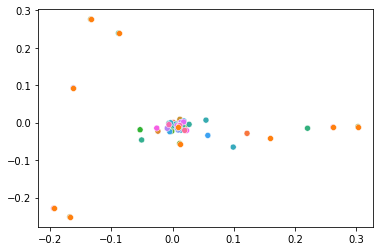

In [34]:
sns.scatterplot(x=temp[:, 0], y=temp[:, 1], hue=templates.index.values, legend=False) # , size=templates_data['size'].values
# sns.scatterplot(x=emoji_data[:, 0], y=emoji_data[:, 1], hue=emoji_df.index.values, legend=False)
sns.scatterplot(x=data[:, 0], y=data[:, 1], legend=False)